# Data Exploration

For an End-to-End machine learning project, we will go through the following steps:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

We will use the California Housing Prices (1990) dataset from the StatLib repository. For teaching purpose I've added a categorical attribute and removed a few features.

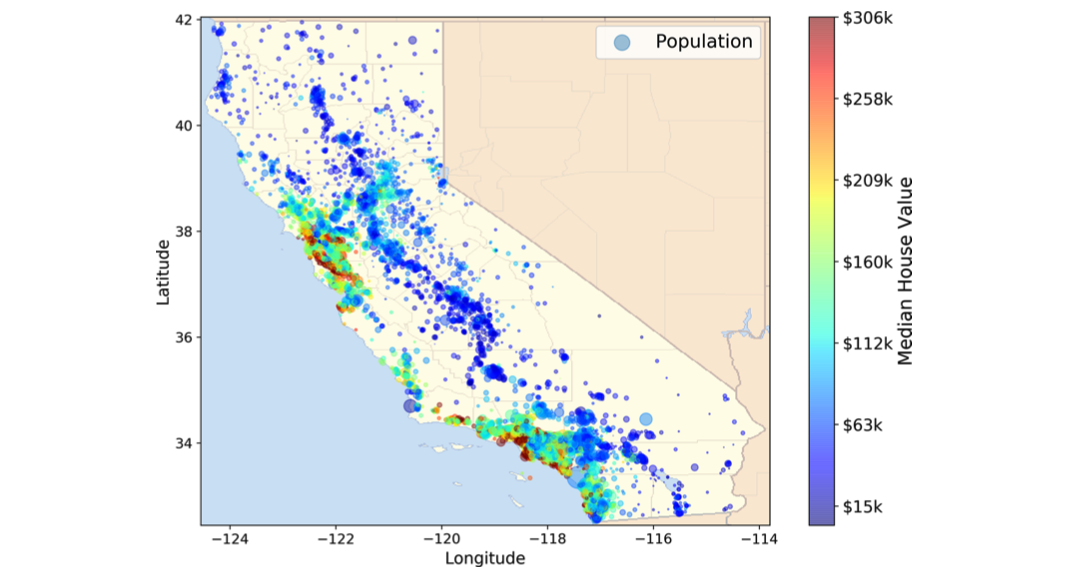

## Frame the problem

This data includes metrics such as the population, median income, and median housing price for each block group in California. your model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals. This downstream system will determine whether it is worth investing in a given area or not.

We need to frame the problem whether it is supervised, unsupervised, or reinforcement learning type problem?

## Select a Performance Measure

We will use the Root Mean Square Error (RMSE). `Evaluation` slides discuss various performance evaluation methods. RMSE corresponds to the *Euclidean norm* whereas MSE corresponds to *L1 norm*. The higher the norm index, the more it focuses on large values and neglects small ones. Hence, RMSE is more sensitive to outliers than the MAE.

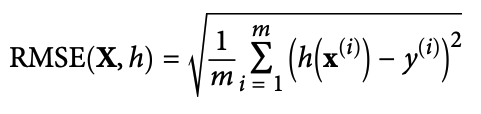

## Download data

We will download a single compressed file which contains a comma-separated values (CSV) file call *housing.csv*.

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

Now let's take a look at the dataset we downloaded.

In [ ]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

Each row represents one district. There are 10 attributes (you can see the first 6 in the screenshot): *longitude, latitude, housing_median_age, total_rooms, total_bed rooms, population, households, median_income, median_house_value*, and *ocean_proximity*.

In [ ]:
housing.info()

In [ ]:
housing["ocean_proximity"].value_counts()

In [ ]:
housing.describe()

Now we want to see the distribution plot. We will use a histogram for that.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(20,15)) 
plt.show()

## Data Preprocessing

In [ ]:
housing["median_income"].hist()

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

In [ ]:
housing['income_cat'].head()

In [ ]:
housing['income_cat'].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

In [ ]:
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
np.random.seed(42)
train_set, test_set = split_train_test(housing, 0.2)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
strat_train_set

## Visualizing Geographical Data

In [ ]:
 housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the alpha option will let you visualize the density of data points.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

You can also apply pre-defined color map.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=housing["population"]/100, label="population", figsize=(10,7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    )
plt.legend()

## Looking for Correlations

you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the `corr()` method:

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix['median_house_value'].sort_values(ascending=False)

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute.

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
                  "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

# Prepare Data for Machine Learning Algorithms

Let's revert to a clean training set

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Most machine learning algorithms cannot work with missing features. Let's creat a few functions to take care of them. We have three options for the missing values:
1. Get rid of the corresponding districts
2. Get rid of the whole attribute
3. Set the values to some value (zero, the mean, the median, etc.)

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:
```
housing.dropna(subset=["total_bedrooms"]) # option 1 
housing.drop("total_bedrooms", axis=1) # option 2 
median = housing["total_bedrooms"].median() # option 3 
housing["total_bedrooms"].fillna(median, inplace=True)
```

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.

In [ ]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")


Since the median can only be computed on numerical attributes, you need to create a copy of the data without the text attribute ocean_proximity:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [ ]:
imputer.fit(housing_num)

In [ ]:
imputer.statistics_

In [ ]:
housing_num.median().values

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

## Handling Text and Categorical Attributes

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

In [ ]:
ordinal_encoder.categories_

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category.

Scikit-Learn provides a OneHotEncoder class to convert categorical values into **one-hot vectors**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
housing_cat_1hot.toarray()

## Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
housing["total_rooms"].describe()

In [ ]:
housing["median_income"].describe()

There are two common ways to get all attributes to have the same scale: **min-max scaling** and **standardization**.

## Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])


In [ ]:
from sklearn.compose import ColumnTransformer 

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train a Model

Let’s first train a Linear Regression model:


In [ ]:
from sklearn.linear_model import LinearRegression 

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Let's try a **Decision Tree** model.

In [ ]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

## Cross-valudiation

Scikit-Learn’s K-fold cross-validation feature. The follow‐ ing code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array con‐ taining the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# Fine-tune Your Model

We need to fine-tune the model. You need to find a great combination of hyperparameter values.

## Grid Search and Random Search

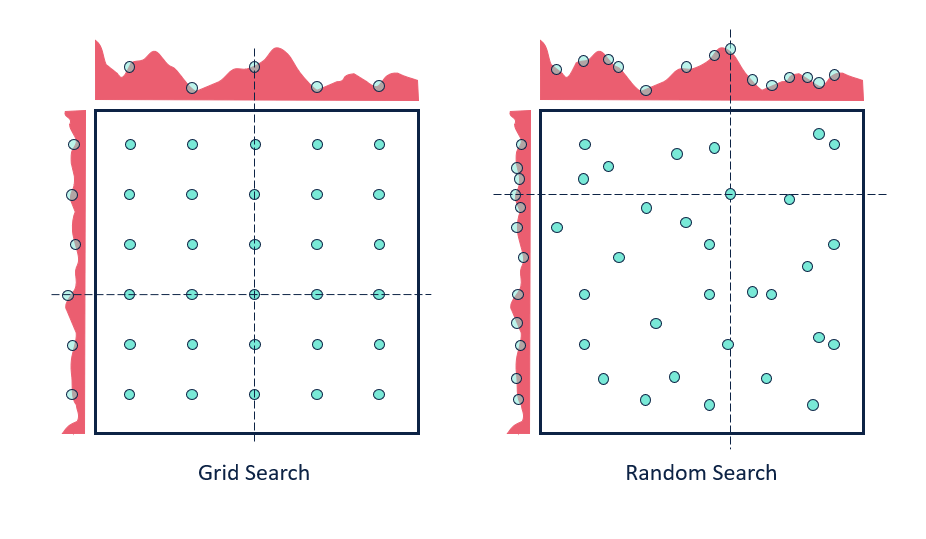

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_

In [ ]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

## Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best. Let's analyze the best models and their errors.


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]

cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

## Final Test

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2
print(f'mse: {final_mse}, rmse: {final_rmse}')